[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rmartimarly/ImageRegistrationTutorial/blob/main/1Intro_image_registration.ipynb)

# Tutorial on Atlas based segmentation

Robert Martí robert.marti@udg.edu
University of Girona



A radiologist comes to your office and asks to help him for a very complicated problem: he has two images of the same patient and wants to find the changes the had happened in the two images: lesions, etc.

![Fixed](https://raw.githubusercontent.com/rmartimarly/ImageRegistrationTutorial/main/files/brain1.png "Fixed")
![Moving](https://raw.githubusercontent.com/rmartimarly/ImageRegistrationTutorial/main/files/brain2_lesion.png "Moving")


Could we measure how similar are two images?

### Import libraries

In [32]:
# !pip install numpy
# !pip install opencv-python
# !pip install pyplot

pip install SimpleITK


In [112]:
import numpy as np
import cv2

%matplotlib inline
# from matplotlib import pyplot as plt
# from matplotlib import cm
# from tensorflow.keras.utils import get_file
# import os

import os
import SimpleITK as sitk
import zipfile
import glob

### Loading images

In [107]:
# Import medical data - we are going to use the head and neck CT data to show the losses.
main_path = os.getcwd()

data_path = "files"
file_path = os.path.abspath(os.path.join(main_path,data_path, "brain_slices_atlas.zip"))
origin = "https://raw.githubusercontent.com/rmartimarly/ImageRegistrationTutorial/main/files/brain_slices_atlas.zip"

if not os.path.exists(data_path):
    os.makedirs(os.path.join(main_path, data_path))


if os.path.exists(file_path):
    os.remove(file_path)   
       
get_file(file_path, origin)
# print("Download sample images: %s." % file_path1)

311296/306683 [==============================] - 0s 0us/step


'/home/robert/src/regTutorial/files/brain_slices_atlas.zip'

In [111]:
atlas_fd = data_path
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(atlas_fd)


In [158]:
atlas_fd= data_path+"/brain_slices_atlas"
int_im = sorted(glob.glob('./'+atlas_fd+'/10??.png'))
lab_im = sorted(glob.glob('./' +atlas_fd+'/*label.png'))


print(int_im[0])
print(lab_im)


./files/brain_slices_atlas/1000.png
['./files/brain_slices_atlas/1000_label.png', './files/brain_slices_atlas/1001_label.png', './files/brain_slices_atlas/1002_label.png', './files/brain_slices_atlas/1006_label.png', './files/brain_slices_atlas/1007_label.png', './files/brain_slices_atlas/1008_label.png', './files/brain_slices_atlas/1009_label.png', './files/brain_slices_atlas/1010_label.png', './files/brain_slices_atlas/1011_label.png']


In [188]:
elastixImageFilter = sitk.ElastixImageFilter()

# choose first image as the fixed
fixed_im = sitk.ReadImage(int_im[0]) 
resultLabels = []

elastixImageFilter.SetFixedImage(fixed_im)
for atlasImage, atlasLabel in zip(int_im[1:-1], lab_im[1:-1]):
    elastixImageFilter.SetMovingImage(sitk.ReadImage(atlasImage))
    elastixImageFilter.Execute()
    label_im = sitk.ReadImage(atlasLabel,sitk.sitkUInt8)
    elastixImageFilter.SetParameter("FinalBSplineInterpolationOrder",'0') # was 8 by default
    tr_label = sitk.Transformix(label_im, elastixImageFilter.GetTransformParameterMap())
    label_cast = sitk.Cast(tr_label,sitk.sitkUInt8)
    resultLabels.append(label_cast)

In [208]:
# label_im = sitk.ReadImage(lab_im[0],sitk.sitkInt8)
# print(type(label_im))
# print(resultLabels[0].GetPixelIDTypeAsString())
# print(label_im.GetPixelIDTypeAsString())
# print(label_im.GetSize())
# print(type(resultLabels))

fixedLabel = sitk.LabelVoting(resultLabels)

print(len(resultLabels))
label_im = sitk.ReadImage(lab_im[0],sitk.sitkUInt8)
sum_t1 = sitk.GetArrayViewFromImage(label_im==85).astype(float)
sum_t2 = sitk.GetArrayViewFromImage(label_im==170).astype(float)
sum_t3 = sitk.GetArrayViewFromImage(label_im==255).astype(float)

for i in range (len(resultLabels)):
    aux =sitk.GetArrayViewFromImage(resultLabels[i])
    sum_t1 = sum_t1 + (aux==85).astype(float)
    sum_t2 = sum_t2 + (aux==170).astype(float)
    sum_t3 = sum_t3 + (aux==255).astype(float)
    
sum_t1 = sum_t1 / len(resultLabels)
sum_t2 = sum_t2 / len(resultLabels)
sum_t3 = sum_t3 / len(resultLabels)


7


35.42857142857143


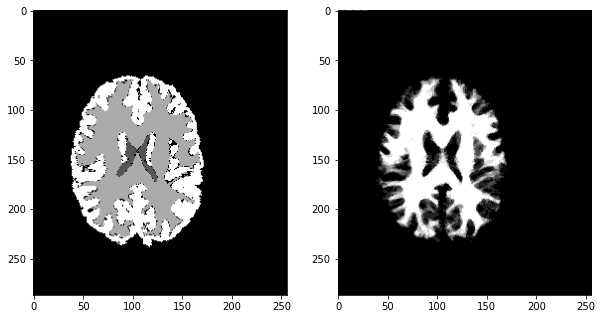

In [230]:
fixed_a = sitk.GetArrayViewFromImage(fixedLabel)

print(np.max(sum_t2))

f = plt.figure(figsize = (10,200))
f.add_subplot(1,2, 1)
plt.imshow(sitk.GetArrayViewFromImage(fixedLabel), cmap='gray')    
f.add_subplot(1,2, 2)
plt.imshow(sum_t2, cmap='gray',clim=(0,1))
plt.show(block=True)

